# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [14]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import thinkstats2

import nsfg
import first

Given a list of values, there are several ways to count the frequency of each value.

In [10]:
t = [1, 2, 2, 3, 5]

You can use a Python dictionary:

In [11]:
hist = {}
for x in t:
    hist[x] = hist.get(x, 0) + 1
    
hist

{1: 1, 2: 2, 3: 1, 5: 1}

You can use a `Counter` (which is a dictionary with additional methods):

In [58]:
from collections import Counter
counter = Counter(t)
counter

Counter({1: 1, 2: 2, 3: 1, 5: 1})

Or you can use the `Hist` object provided by `thinkstats2`:

In [15]:
import thinkstats2
hist = thinkstats2.Hist([1, 2, 2, 3, 5])
hist

Hist({1: 1, 2: 2, 3: 1, 5: 1})

In [16]:
abc = thinkstats2.Hist(t)
abc

Hist({1: 1, 2: 2, 3: 1, 5: 1})

`Hist` provides `Freq`, which looks up the frequency of a value.

In [17]:
hist.Freq(2)

2

You can also use the bracket operator, which does the same thing.

In [61]:
hist[2]

2

If the value does not appear, it has frequency 0.

In [18]:
hist[4]

0

The `Values` method returns the values:

In [63]:
hist.Values()

dict_keys([1, 2, 3, 5])

So you can iterate the values and their frequencies like this:

In [64]:
for val in sorted(hist.Values()):
    print(val, hist[val])

1 1
2 2
3 1
5 1


Or you can use the `Items` method:

In [65]:
for val, freq in hist.Items():
     print(val, freq)

1 1
2 2
3 1
5 1


`thinkplot` is a wrapper for `matplotlib` that provides functions that work with the objects in `thinkstats2`.

For example `Hist` plots the values and their frequencies as a bar graph.

`Config` takes parameters that label the x and y axes, among other things.

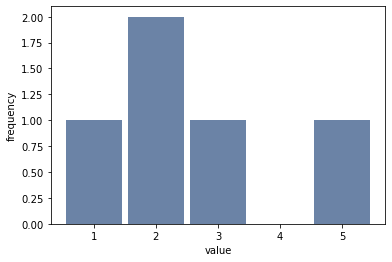

In [22]:
import thinkplot
thinkplot.Hist(hist)
thinkplot.Config(xlabel='value', ylabel='frequency')

As an example, I'll replicate some of the figures from the book.

First, I'll load the data from the pregnancy file and select the records for live births.

In [23]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]

Here's the histogram of birth weights in pounds.  Notice that `Hist` works with anything iterable, including a Pandas Series.  The `label` attribute appears in the legend when you plot the `Hist`. 

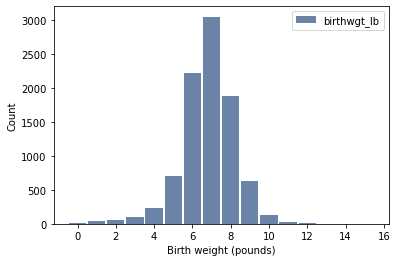

In [24]:
hist = thinkstats2.Hist(live.birthwgt_lb, label='birthwgt_lb')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='Count')

Before plotting the ages, I'll apply `floor` to round down:

In [28]:
ages = np.floor(live.agepreg)
ages

0        33.0
1        39.0
2        14.0
3        17.0
4        18.0
         ... 
13581    30.0
13584    26.0
13588    17.0
13591    21.0
13592    21.0
Name: agepreg, Length: 9148, dtype: float64

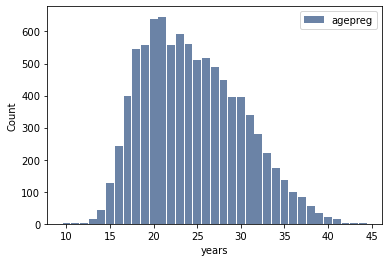

In [29]:
hist = thinkstats2.Hist(ages, label='agepreg')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='years', ylabel='Count')

As an exercise, plot the histogram of pregnancy lengths (column `prglngth`).

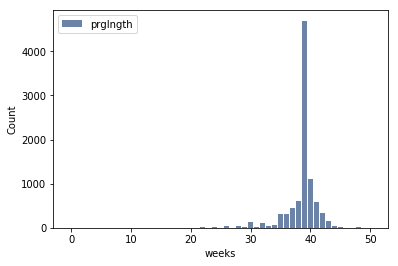

In [71]:
# Solution goes here
hist = thinkstats2.Hist(live.prglngth, label='prglngth')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='weeks', ylabel='Count')

`Hist` provides smallest, which select the lowest values and their frequencies.

In [72]:
for weeks, freq in hist.Smallest(10):
    print(weeks, freq)

0 1
4 1
9 1
13 1
17 2
18 1
19 1
20 1
21 2
22 7


Use `Largest` to display the longest pregnancy lengths.

In [73]:
# Solution goes here
for weeks, freq in hist.Largest(10):
    print(weeks, freq)

50 2
48 7
47 1
46 1
45 10
44 46
43 148
42 328
41 587
40 1116


From live births, we can select first babies and others using `birthord`, then compute histograms of pregnancy length for the two groups.

In [74]:
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

first_hist = thinkstats2.Hist(firsts.prglngth, label='first')
other_hist = thinkstats2.Hist(others.prglngth, label='other')

We can use `width` and `align` to plot two histograms side-by-side.

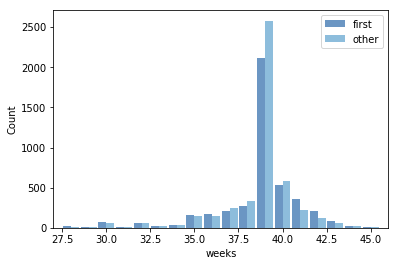

In [75]:
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(first_hist, align='right', width=width)
thinkplot.Hist(other_hist, align='left', width=width)
thinkplot.Config(xlabel='weeks', ylabel='Count', xlim=[27, 46])

`Series` provides methods to compute summary statistics:

In [76]:
mean = live.prglngth.mean()
var = live.prglngth.var()
std = live.prglngth.std()

Here are the mean and standard deviation:

In [77]:
mean, std

(38.56055968517709, 2.702343810070593)

As an exercise, confirm that `std` is the square root of `var`:

In [78]:
# Solution goes here
mean = sum(live.prglngth)/len(live.prglngth)
var = sum((live.prglngth-mean)**2)/len(live.prglngth)
std = np.sqrt(var)

mean, var, std

(38.56055968517709, 7.301863788195474, 2.7021961046888276)

Here's are the mean pregnancy lengths for first babies and others:

In [79]:
firsts.prglngth.mean(), others.prglngth.mean()

(38.60095173351461, 38.52291446673706)

And here's the difference (in weeks):

In [80]:
firsts.prglngth.mean() - others.prglngth.mean()

0.07803726677754952

This functon computes the Cohen effect size, which is the difference in means expressed in number of standard deviations:

In [81]:
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups.
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Compute the Cohen effect size for the difference in pregnancy length for first babies and others.

In [82]:
# Solution goes here
CohenEffectSize(firsts.prglngth, others.prglngth)

0.028879044654449883

## Exercises

Using the variable `totalwgt_lb`, investigate whether first babies are lighter or heavier than others. 

Compute Cohen’s effect size to quantify the difference between the groups.  How does it compare to the difference in pregnancy length?

In [83]:
# Solution goes here
firsts.totalwgt_lb.mean(), others.totalwgt_lb.mean()

(7.201094430437772, 7.325855614973262)

In [84]:
# Solution goes here
CohenEffectSize(firsts.totalwgt_lb, others.totalwgt_lb)

-0.088672927072602

For the next few exercises, we'll load the respondent file:

In [85]:
resp = nsfg.ReadFemResp()

Make a histogram of <tt>totincr</tt> the total income for the respondent's family.  To interpret the codes see the [codebook](http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=FEM&section=R&subSec=7876&srtLabel=607543).

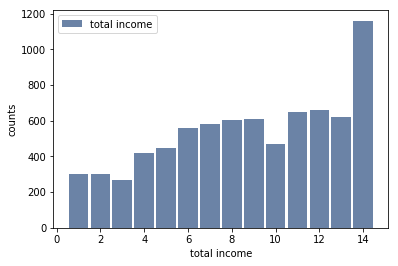

In [86]:
# Solution goes here
hist = thinkstats2.Hist(resp.totincr, label='total income')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='total income', ylabel='counts')

Make a histogram of <tt>age_r</tt>, the respondent's age at the time of interview.

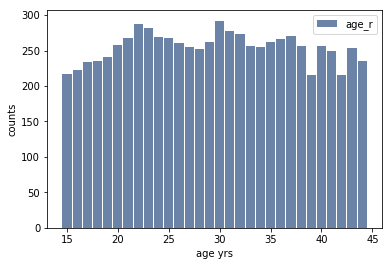

In [87]:
# Solution goes here
hist = thinkstats2.Hist(resp.age_r, label='age_r')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='age yrs', ylabel='counts')

Make a histogram of <tt>numfmhh</tt>, the number of people in the respondent's household.

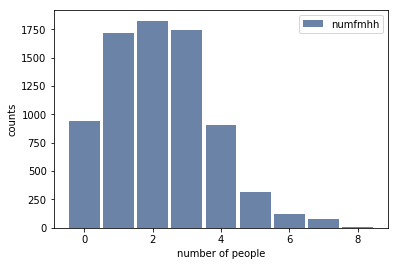

In [88]:
# Solution goes here
hist = thinkstats2.Hist(resp.numfmhh, label='numfmhh')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='number of people', ylabel='counts')

Make a histogram of <tt>parity</tt>, the number of children borne by the respondent.  How would you describe this distribution?

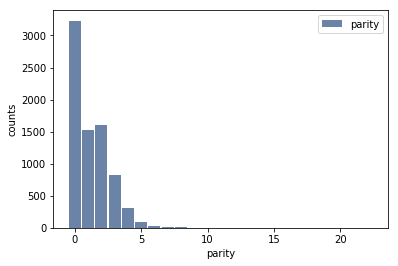

In [89]:
# Solution goes here
hist = thinkstats2.Hist(resp.parity, label='parity')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='parity', ylabel='counts')

Use Hist.Largest to find the largest values of <tt>parity</tt>.

In [90]:
# Solution goes here
hist.Largest(10)
   

[(22, 1),
 (16, 1),
 (10, 3),
 (9, 2),
 (8, 8),
 (7, 15),
 (6, 29),
 (5, 95),
 (4, 309),
 (3, 828)]

Let's investigate whether people with higher income have higher parity.  Keep in mind that in this study, we are observing different people at different times during their lives, so this data is not the best choice for answering this question.  But for now let's take it at face value.

Use <tt>totincr</tt> to select the respondents with the highest income (level 14).  Plot the histogram of <tt>parity</tt> for just the high income respondents.

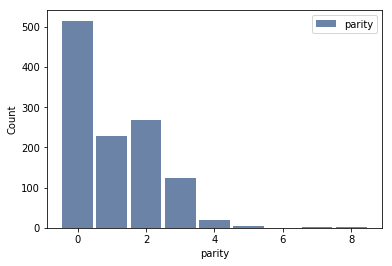

In [91]:
# Solution goes here
rich = resp[resp.totincr==14]
hist = thinkstats2.Hist(rich.parity)
thinkplot.Hist(hist, label='parity')
thinkplot.Config(xlabel='parity', ylabel='Count')

Find the largest parities for high income respondents.

In [92]:
# Solution goes here
hist.Largest(10)

[(8, 1), (7, 1), (5, 5), (4, 19), (3, 123), (2, 267), (1, 229), (0, 515)]

Compare the mean <tt>parity</tt> for high income respondents and others.

In [93]:
# Solution goes here
others = resp[resp.totincr < 14]

rich.parity.mean(), others.parity.mean()

(1.0758620689655172, 1.2495758136665125)

Compute the Cohen effect size for this difference.  How does it compare with the difference in pregnancy length for first babies and others?

In [94]:
# Solution goes here
CohenEffectSize(rich.parity, others.parity)

-0.1251185531466061